In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
# from snntorch.spikeplot import plot_snn_spikes

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [193]:
def make_weight_matrix(n_src, n_target, w_min=0.0, w_max=1.0, prob=0.5, seed=0):
    torch.manual_seed(seed)
    prob_mask = (torch.rand((n_src, n_target)) < prob).float()
    weight_matrix = torch.rand((n_src, n_target)) * (w_max - w_min) + w_min

    return weight_matrix * prob_mask


n_E = 1000
n_I = 300

num_steps = 500

neuron_dict = {
    'E': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_E, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.3, 'bkg_rate': 0.1},
    'I': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_I, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.3, 'bkg_rate': 0.1},
}

num_neurons = n_E + n_I

conn_dict = {
    'EI': {'w_min': 0.0, 'w_max': 10.0, 'prob': 0.3},
    'IE': {'w_min': -10.0, 'w_max': 0.0, 'prob': 0.8},
    'EE': {'w_min': 0.0, 'w_max': 10.0, 'prob': 0.1},
    'II': {'w_min': -10.0, 'w_max': 0.0, 'prob': 0.8},
}

snn_dict = dict()
rec_dict = dict()
seed_count = 0
for src_name, src_dict in neuron_dict.items():
    snn_dict[src_name] = snn.Lapicque(beta=src_dict['beta'], threshold=src_dict['threshold'])


    spk_bkg = spikegen.rate_conv(torch.ones((num_steps, src_dict['num_neuron'])) * src_dict['bkg_rate']).unsqueeze(1)
    bkg_weight = make_weight_matrix(
                    n_src=src_dict['num_neuron'],
                    n_target=src_dict['num_neuron'],
                    w_min=src_dict['bkg_min'],
                    w_max=src_dict['bkg_max'],
                    prob=src_dict['bkg_prob'],
                    seed=seed_count)
    neuron_dict[src_name]['bkg_weight'] = bkg_weight

    seed_count += 1
    rec_dict[src_name] = {'mem': list(), 'spk': list(), 'spk_bkg': spk_bkg}
    for target_name, target_dict in neuron_dict.items():
        conn_name = f'{src_name}{target_name}'
        conn_dict[conn_name]['weight'] = make_weight_matrix(
            n_src=src_dict['num_neuron'],
            n_target=target_dict['num_neuron'],
            w_min=conn_dict[conn_name]['w_min'],
            w_max=conn_dict[conn_name]['w_max'],
            prob=conn_dict[conn_name]['prob'],
            seed=seed_count
        )
        seed_count += 1

In [187]:
# Initialize hidden states
for cell_name in snn_dict.keys():
    cur = torch.matmul(rec_dict[cell_name]['spk_bkg'][0], neuron_dict[cell_name]['bkg_weight'])
    spk, mem = snn_dict[cell_name](cur, snn_dict[cell_name].init_leaky())

    rec_dict[cell_name]['mem'] = [mem]
    rec_dict[cell_name]['spk'] = [spk] 


# network simulation
for step in range(1, num_steps):
    for target_name in neuron_dict.keys():
        cur = torch.matmul(rec_dict[target_name]['spk_bkg'][step], neuron_dict[target_name]['bkg_weight'])
        
        for src_name in neuron_dict.keys():
            conn_name = f'{src_name}{target_name}'
            weight = conn_dict[conn_name]['weight']

            cur += torch.matmul(rec_dict[src_name]['spk'][-1], weight)

        spk, mem = snn_dict[target_name](cur, rec_dict[target_name]['mem'][-1])

        rec_dict[target_name]['mem'].append(mem)
        rec_dict[target_name]['spk'].append(spk) 
     
        weight = conn_dict[conn_name]['weight']


# convert lists to tensors
for cell_name in snn_dict.keys():
    rec_dict[cell_name]['mem'] = torch.stack(rec_dict[cell_name]['mem']).squeeze()
    rec_dict[cell_name]['spk'] = torch.stack(rec_dict[cell_name]['spk']).squeeze()


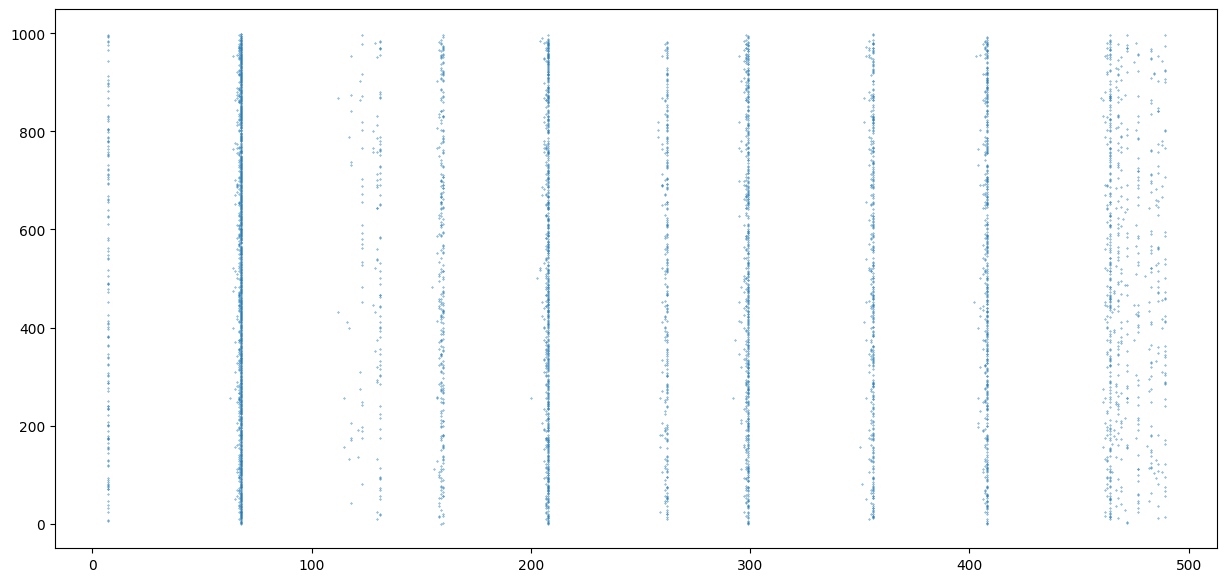

In [192]:
plt.figure(figsize=(15, 7))
t_idx, unit_idx = np.where(rec_dict['E']['spk'].detach().numpy() == 1.0)
plt.scatter(t_idx, unit_idx, s=0.1)
# plt.xlim(0, 1000)

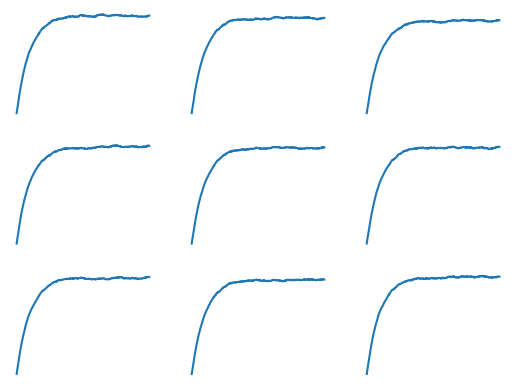

In [125]:
splt.traces(rec_dict['E']['mem'].squeeze()[:, 100:110], spk=rec_dict['E']['spk'].squeeze()[:,100:110])

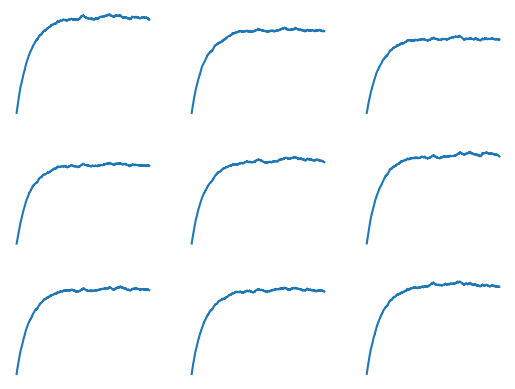

In [126]:
splt.traces(rec_dict['I']['mem'].squeeze()[:, 0:20], spk=rec_dict['I']['spk'].squeeze()[:,0:20])

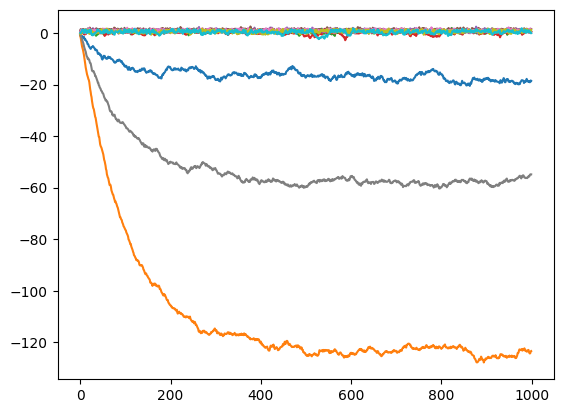

In [68]:
_ = plt.plot(mem1_rec[:,100:110])
# plt.ylim(-10, 10)

In [27]:
spk1_rec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [70]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)

# network simulation
for step in range(200):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

In [85]:
splt.traces(mem1_rec, spk=spk1_rec)

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.